# Data Transformations before Modeling Process

Note: some of preliminary methodogy for merging datasets and cleaning to set up data for training/testing is taken from https://www.kaggle.com/code/raddar/vilnius-ncaa which is a submission from the Kaggle competition the code is taken from. We will be adding other external attributes (including Pomeroy rankings and Autodraft logic) and using a different modeling process

# Importing CSV files from Kaggle

In [325]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
os.getcwd()

'/Users/ellawileman/Documents/spring2025/data mining/data_mining_course_project'

In [326]:
regular_results = pd.read_csv("MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("MNCAATourneyDetailedResults.csv")
seeds = pd.read_csv("MNCAATourneySeeds.csv")
teams = pd.read_csv("MTeams.csv")

In [327]:
display(regular_results.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [328]:
# Ensuring earliest year in datasets is 2003 (Consistent with Pomeroy Rankings)
print(min(regular_results["Season"].value_counts().index))
print(min(tourney_results["Season"].value_counts().index))
seeds = seeds.loc[seeds["Season"] >= 2003]
print(min(seeds["Season"].value_counts().index))

2003
2003
2003


In [329]:
# how many teams in each season
teams["TeamID"].nunique()

380

For visualization purposes: can see how a team performs over the course of its regular season and its tournament for each season. 

In [330]:
# let's take one random team and see its journey during the 2024 season
season = 2024
teamid = 1104

# showing regular season going into the tournament and tournament data for the year
r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
]
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
]
r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
r["type"] = "regular season"
t["type"] = "tournament"

rt = pd.concat([r, t])
rt[["DayNum", "WScore", "LScore", "type", "win"]]

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_45976/632077965.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_45976/632077965.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_45976/632077965.py:16: SettingWithCopyWarning: 
A value is trying to be set on 

,DayNum,WScore,LScore,type,win
107636,0,105,73,regular season,win
107805,4,102,80,regular season,win
107979,8,102,46,regular season,win
108100,11,98,67,regular season,win
108506,18,92,81,regular season,lose
108528,19,99,91,regular season,win
108655,22,85,77,regular season,lose
108930,28,89,65,regular season,win
109117,33,92,86,regular season,lose
109262,40,85,82,regular season,lose


In [331]:
# Looking into format of "seeds" table 
seeds.reset_index(drop=True, inplace=True)
s = seeds.loc[seeds["Season"] == 2003]
[s.loc[s["Seed"].str.startswith(d)] for d in ("X", "Y", "Z", "W")]
# Note that X, Y, Z, W are the divisions and each will have its own seed. 

[    Season  Seed  TeamID
 16    2003   X01    1400
 17    2003   X02    1196
 18    2003   X03    1462
 19    2003   X04    1390
 20    2003   X05    1163
 21    2003   X06    1268
 22    2003   X07    1277
 23    2003   X08    1261
 24    2003   X09    1345
 25    2003   X10    1160
 26    2003   X11    1423
 27    2003   X12    1140
 28    2003   X13    1360
 29    2003   X14    1407
 30    2003   X15    1358
 31    2003  X16a    1411
 32    2003  X16b    1421,
     Season Seed  TeamID
 33    2003  Y01    1246
 34    2003  Y02    1338
 35    2003  Y03    1266
 36    2003  Y04    1173
 37    2003  Y05    1458
 38    2003  Y06    1281
 39    2003  Y07    1231
 40    2003  Y08    1332
 41    2003  Y09    1428
 42    2003  Y10    1104
 43    2003  Y11    1356
 44    2003  Y12    1451
 45    2003  Y13    1409
 46    2003  Y14    1221
 47    2003  Y15    1447
 48    2003  Y16    1237,
     Season Seed  TeamID
 49    2003  Z01    1112
 50    2003  Z02    1242
 51    2003  Z03    1181
 52  

# Double the dataset with swapped team positions in box scores
- Avoid bias from putting team in T1 position (on left vs. right)
- Help model generalize rather than learn teams specific position

In [332]:
# double the dataset with swapped team positions in box scores
def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    

    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    # selecting which columns to adjust (not Season, DayNum, LTeamID, WTeamID))
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    # Swapping team positions
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    # if positive point diff (assuming team 1 is the winner or loser we consider), then team 1 wins
    output["win"] = (output["PointDiff"] > 0) * 1
    # output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_45976/3766623745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / adjot
/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_45976/3766623745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col] / adjot


In [333]:
display(regular_data.head())

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,...,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win
0,2003,10,1328,62.0,1104,68.0,0,22.0,53.0,2.0,...,18.0,14.0,24.0,13.0,23.0,7.0,1.0,22.0,6.0,1
1,2003,10,1393,63.0,1272,70.0,0,24.0,67.0,6.0,...,19.0,15.0,28.0,16.0,13.0,4.0,4.0,18.0,7.0,1
2,2003,11,1437,61.0,1266,73.0,0,22.0,73.0,3.0,...,29.0,17.0,26.0,15.0,10.0,5.0,2.0,25.0,12.0,1
3,2003,11,1457,50.0,1296,56.0,0,18.0,49.0,6.0,...,31.0,6.0,19.0,11.0,12.0,14.0,2.0,18.0,6.0,1
4,2003,11,1208,71.0,1400,77.0,0,24.0,62.0,6.0,...,13.0,17.0,22.0,12.0,14.0,4.0,4.0,20.0,6.0,1


# Want tourney data for **labels** to train on

In [ ]:
massey_ordinals = pd.read_csv("PreTourneyMasseyOrdinals.csv")
# selecting only columns we want to merge in 
massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
display(massey.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
massey.dtypes

,Season,TeamID,OrdinalRank
0,2003,1102,159
1,2003,1103,229
2,2003,1104,12
3,2003,1105,314
4,2003,1106,260


Season         int64
TeamID         int64
OrdinalRank    int64
dtype: object

In [335]:
# grabbing numeric part of seed and converting to int ( we still want to keep the division info)
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))

seeds_T1 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed"]

# merging seeds (for each team) with tourney data
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win",]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]
# dont need individual seeds for each team if have difference
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "Seed_diff"]]
display(tourney_data)

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff
0,2003,1421,1411,7.111111,1,0
1,2003,1112,1436,29.000000,1,15
2,2003,1113,1272,13.000000,1,-3
3,2003,1141,1166,6.000000,1,-5
4,2003,1143,1301,1.777778,1,1
...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,7
2760,2024,1397,1345,-6.000000,0,-1
2761,2024,1104,1163,-14.000000,0,-3
2762,2024,1301,1345,-13.000000,0,-10


<Axes: xlabel='Seed_diff', ylabel='PointDiff'>

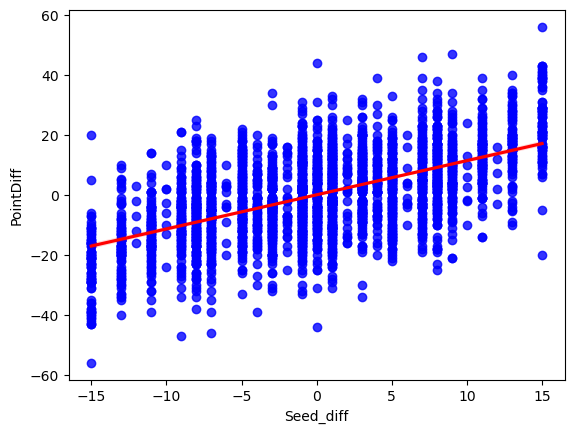

In [336]:
# seed difference vs point difference (between Team 1 and Team 2)
sns.regplot(x=tourney_data["Seed_diff"], y=tourney_data["PointDiff"], color='blue', line_kws={"color": "red"})

# Aggregating Game Stats: Offensive/Defensive for *Each T1 and T2*

In [337]:
# From MRegularSeasonDetailedResults and some of ourcalculations (point diff)
# box score columns, for which we want features to our model
boxcols = [
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

# Regular season is **attributes** we train on

In [338]:
# calculate season averages for each team 
# for each team, we take the mean of the box score columns (for each unique instance of team T1 and year)
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

# merging season averages with tourney data
tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2003,1421,1411,7.111111,1,0,69.615326,23.847510,55.639847,6.348659,...,11.914815,18.655556,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148
1,2003,1112,1436,29.000000,1,15,84.511905,30.067460,65.087302,6.984127,...,10.331034,15.482759,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655
2,2003,1113,1272,13.000000,1,-3,75.344828,27.003831,56.436782,3.977011,...,13.333333,20.659004,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487
3,2003,1141,1166,6.000000,1,-5,79.344828,26.620690,52.689655,6.827586,...,11.643098,16.619529,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990
4,2003,1143,1301,1.777778,1,1,73.636015,27.015326,57.946360,6.314176,...,15.374074,21.129630,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370


In [339]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'T1_avg_Score', 'T1_avg_FGM', 'T1_avg_FGA', 'T1_avg_FGM3',
       'T1_avg_FGA3', 'T1_avg_FTM', 'T1_avg_FTA', 'T1_avg_OR', 'T1_avg_DR',
       'T1_avg_Ast', 'T1_avg_TO', 'T1_avg_Stl', 'T1_avg_Blk', 'T1_avg_PF',
       'T1_avg_opponent_Score', 'T1_avg_opponent_FGM', 'T1_avg_opponent_FGA',
       'T1_avg_opponent_FGM3', 'T1_avg_opponent_FGA3', 'T1_avg_opponent_FTM',
       'T1_avg_opponent_FTA', 'T1_avg_opponent_OR', 'T1_avg_opponent_DR',
       'T1_avg_opponent_Ast', 'T1_avg_opponent_TO', 'T1_avg_opponent_Stl',
       'T1_avg_opponent_Blk', 'T1_avg_opponent_PF', 'T1_avg_PointDiff',
       'T2_avg_Score', 'T2_avg_FGM', 'T2_avg_FGA', 'T2_avg_FGM3',
       'T2_avg_FGA3', 'T2_avg_FTM', 'T2_avg_FTA', 'T2_avg_OR', 'T2_avg_DR',
       'T2_avg_Ast', 'T2_avg_TO', 'T2_avg_Stl', 'T2_avg_Blk', 'T2_avg_PF',
       'T2_avg_opponent_Score', 'T2_avg_opponent_FGM', 'T2_avg_opponent_FGA',
       'T2_avg_opponent_FGM3', 'T2_

Basically, tourney schedule is deciding WHICH matchups we use in training set (and who won!), seeds, and point differences.
For each team in the match up, we are going to include its season averages in play statistics IN this row. This way, we are training on during-season data to see if we can predict tournament matchup results (our bracket)

# Questions: 
- Should we be subtracting or taking ratios between T1 and T2 stats so we can get relative stats? 
- Do we want ALL of these during game stats or do we just want certain ones? We can start with all and use some systematic feature selection because we don't have too much field knowledge

Note: to add: massey ordinals rankings (diff?), pomeroy ratings (diff?), conference 

Need to choose ranking or few from all possible Massey Ranking Systems

In [340]:
massey_ordinals = pd.read_csv("PreTourneyMasseyOrdinals.csv")
# selecting only columns we want to merge in 
#massey = massey_ordinals[["Season", "TeamID", "OrdinalRank"]].copy()
#display(massey_ordinals.head())
# we want to take the OrinalRank column and merge it with our tourney data (for each team T1 and T2 on its team id)
# means need to merge twice like shown above
pre_tourney_massey = massey_ordinals[massey_ordinals["RankingDayNum"] == 133]
display(pre_tourney_massey.head())
pre_tourney_massey["SystemName"].value_counts()
# would only choose ranking system where we have all teams pre tournament (day 133) rankings for each year
# or at least as many as possible (dont mind cutting a few teams that wouldn't be ranked and therefore not in the tournament)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
121021,2003,133,AP,1112,2
121022,2003,133,AP,1163,23
121023,2003,133,AP,1166,15
121024,2003,133,AP,1173,16
121025,2003,133,AP,1181,7


SystemName
WOL    2341
SAG    2341
BOB    2341
RTH    2341
MOR    2341
       ... 
JON     326
AP      176
USA     175
DES     100
TRX      80
Name: count, Length: 85, dtype: int64

From source: https://kenpom.com (also includes meaning for each field)

Compared to our original 80 teams:

In [341]:
# Group by 'systemName' and count distinct teams in 'TeamID' (or the relevant column for teams)
distinct_teams_per_system = pre_tourney_massey.groupby('SystemName')['TeamID'].nunique().sort_values(ascending=False)

print(distinct_teams_per_system[distinct_teams_per_system == 349])

# comparing to abbreviation mappings on Massey site:
# can't find DUN, SAG, SEL, BOB, SE
# RTH is Rothman
# MOR is Moore
# WOL is Wolfe

# creating least amount of missing values after merges/joins by selecting the system with most teams
# less imputation or dropped values needed. generating complete-case training instances 


SystemName
DUN    349
SAG    349
SEL    349
RTH    349
MOR    349
BOB    349
SE     349
WOL    349
Name: TeamID, dtype: int64


In [342]:
# Filtering for only these ranking systems 
pre_tourney_massey = pre_tourney_massey.loc[(pre_tourney_massey["SystemName"] == "RTH") | (pre_tourney_massey["SystemName"] == "MOR") | (pre_tourney_massey["SystemName"] == "WOL")]
display(pre_tourney_massey.head())

# Now that we only have 3 ranking systems, convert system name to columns 

# pivot the data to have systemName as columns
pivoted_massey = pre_tourney_massey.pivot(index=['TeamID', 'Season'], columns='SystemName', values='OrdinalRank').reset_index()
print(pivoted_massey)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
126932,2003,133,MOR,1102,132
126933,2003,133,MOR,1103,139
126934,2003,133,MOR,1104,26
126935,2003,133,MOR,1105,309
126936,2003,133,MOR,1106,294


SystemName  TeamID  Season  MOR  RTH  WOL
0             1102    2003  132  146  157
1             1102    2004   61   51   48
2             1102    2005   60   80   97
3             1102    2006   58   52   52
4             1102    2007   62   44   30
...            ...     ...  ...  ...  ...
2336          1464    2005  294  306  315
2337          1464    2006  270  265  293
2338          1464    2007  199  177  175
2339          1464    2008  225  207  226
2340          1464    2009  177  217  234

[2341 rows x 5 columns]


In [343]:
#test = pd.merge(tourney_data, massey, left_on=["Season", "T2_TeamID"], right_on=["Season", "TeamID"], how="left")

In [344]:
# We will be combining in this data from Pomeroy rankings (external source)
pomeroy = pd.read_csv("KenPom Stats.csv")
pomeroy = pomeroy.dropna()
pomeroy = pomeroy.drop(columns=[col for col in pomeroy.columns if "_rank" in col])
pomeroy["YEAR"] = pomeroy["YEAR"].astype(int)
# remove periods from team name column 
pomeroy['Team'] = pomeroy['Team'].str.replace('.', '', regex=False)
dat= pd.merge(pomeroy, teams[["TeamID", "TeamName"]], how='inner',left_on="Team", right_on="TeamName")
dat = dat.drop(columns=dat.columns[-1])

print(pomeroy["Team"].nunique())
print(dat["Team"].nunique())
display(dat)

# for this file we can use the ranking for each stat (its built in) and maybe use some differences
# because we also have the raw value for these statistics, idk which we would want

# mapping to this table's year and Team id (team id to team name table)

/var/folders/yz/btvl331d4g54624wdzgx_2hc0000gn/T/ipykernel_45976/1074537758.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  pomeroy = pd.read_csv("KenPom Stats.csv")


395
290


,Rk,Team,Conf,W_L,NetRtg,ORtg,DRtg,AdjT,Luck,SchedStrengthNetRtg,SchedStrengthORtg,SchedStrengthDRtg,NCSOSNetRtg,YEAR,TeamID
0,1.0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1246
1,2.0,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,1242
2,3.0,Pittsburgh,BE,28-5,28.61,114.8,86.2,64.7,-0.023,7.08,105.5,98.4,-8.24,2003,1338
3,4.0,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1112
4,5.0,Illinois,B10,25-7,24.47,113.2,88.7,67.8,-0.029,7.29,105.8,98.5,-4.18,2003,1228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,356.0,New Hampshire,AE,24-Aug,-21.72,93.9,115.6,67.6,0.019,-6.16,103.7,109.9,-3.50,2025,1306
6218,359.0,Canisius,MAAC,28-Mar,-23.01,99.1,122.1,66.4,-0.078,-4.88,103.0,107.9,3.86,2025,1145
6219,360.0,Alabama A&M,SWAC,22-Oct,-23.36,92.2,115.6,71.2,-0.022,-9.57,101.3,110.8,1.93,2025,1105
6220,361.0,Coppin St,MEAC,24-Jun,-24.40,87.4,111.8,68.0,0.033,-4.43,105.3,109.8,4.14,2025,1164


Note that with using pomeroy data we are gonna be reducing the number of teams, but these teams not considered likely won't be tournament games we care about. We can make that call

To do list

In [345]:
# add in the massey ordinals - NEED TO CHOOSE SYSTEM
# add in pomeroy rankings (delete all columns with rank because are showing what rank that team would be in terms of that stat)
# take all differences T1 - T2 for each stat
# can keep the point differences and win/loss columns (we can decide later when fitting models if we want numeric or binary label)
# export to csv 
# bring into weka - start looking at correlations of our final dataset 

In [346]:
# Merge pomeroy ORtg and DRtg for T1
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg']],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T1_ORtg',
    'DRtg': 'T1_Drtg'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg
0,2003,1421,1411,7.111111,1,0,69.615326,23.847510,55.639847,6.348659,...,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5
1,2003,1112,1436,29.000000,1,15,84.511905,30.067460,65.087302,6.984127,...,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8
2,2003,1113,1272,13.000000,1,-3,75.344828,27.003831,56.436782,3.977011,...,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4
3,2003,1141,1166,6.000000,1,-5,79.344828,26.620690,52.689655,6.827586,...,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN
4,2003,1143,1301,1.777778,1,1,73.636015,27.015326,57.946360,6.314176,...,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,7,79.843750,28.531250,59.218750,8.343750,...,8.370370,24.092593,12.447531,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2
2760,2024,1397,1345,-6.000000,0,-1,79.468750,27.437500,61.750000,8.718750,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2
2761,2024,1104,1163,-14.000000,0,-3,90.090278,30.663194,64.197917,11.003472,...,7.588235,18.441176,10.382353,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0
2762,2024,1301,1345,-13.000000,0,-10,75.712963,27.145062,60.398148,7.009259,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4


In [347]:
#tourney_data = tourney_data.iloc[:, :-8]
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg
0,2003,1421,1411,7.111111,1,0,69.615326,23.847510,55.639847,6.348659,...,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5
1,2003,1112,1436,29.000000,1,15,84.511905,30.067460,65.087302,6.984127,...,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8
2,2003,1113,1272,13.000000,1,-3,75.344828,27.003831,56.436782,3.977011,...,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4
3,2003,1141,1166,6.000000,1,-5,79.344828,26.620690,52.689655,6.827586,...,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN
4,2003,1143,1301,1.777778,1,1,73.636015,27.015326,57.946360,6.314176,...,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,7,79.843750,28.531250,59.218750,8.343750,...,8.370370,24.092593,12.447531,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2
2760,2024,1397,1345,-6.000000,0,-1,79.468750,27.437500,61.750000,8.718750,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2
2761,2024,1104,1163,-14.000000,0,-3,90.090278,30.663194,64.197917,11.003472,...,7.588235,18.441176,10.382353,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0
2762,2024,1301,1345,-13.000000,0,-10,75.712963,27.145062,60.398148,7.009259,...,8.033670,18.622896,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4


In [348]:
# Merge pomeroy ORtg and DRtg for T2
tourney_data = tourney_data.merge(
    dat[['TeamID', 'YEAR', 'ORtg', 'DRtg']],
    how='left', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'YEAR']
).rename(columns={
    'ORtg': 'T2_ORtg',
    'DRtg': 'T2_Drtg'
}).drop(columns=['TeamID', 'YEAR'])

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg
0,2003,1421,1411,7.111111,1,0,69.615326,23.847510,55.639847,6.348659,...,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN
1,2003,1112,1436,29.000000,1,15,84.511905,30.067460,65.087302,6.984127,...,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655,115.6,88.8,101.1,99.5
2,2003,1113,1272,13.000000,1,-3,75.344828,27.003831,56.436782,3.977011,...,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487,113.9,97.4,110.9,94.1
3,2003,1141,1166,6.000000,1,-5,79.344828,26.620690,52.689655,6.827586,...,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990,NaN,NaN,112.4,94.9
4,2003,1143,1301,1.777778,1,1,73.636015,27.015326,57.946360,6.314176,...,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370,109.9,96.3,111.2,98.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,7,79.843750,28.531250,59.218750,8.343750,...,12.447531,11.459877,5.145062,3.061728,16.077160,3.641975,121.6,95.2,114.3,98.4
2760,2024,1397,1345,-6.000000,0,-1,79.468750,27.437500,61.750000,8.718750,...,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,116.8,90.2,125.2,94.6
2761,2024,1104,1163,-14.000000,0,-3,90.090278,30.663194,64.197917,11.003472,...,10.382353,10.088235,5.500000,2.882353,16.852941,17.058824,126.0,103.0,127.5,91.1
2762,2024,1301,1345,-13.000000,0,-10,75.712963,27.145062,60.398148,7.009259,...,14.212121,9.461279,6.774411,2.262626,20.373737,13.228956,114.3,98.4,125.2,94.6


In [349]:
# Merge massey ordinals for T1 (using selected 3 ranking systems explained above)
tourney_data = tourney_data.merge(
    pivoted_massey[['TeamID', 'Season', 'MOR', 'RTH', 'WOL']],
    how='left', 
    left_on=['T1_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'MOR': 'T1_MOR',
    'RTH': 'T1_RTH',
    'WOL': 'T1_WOL'
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg,T1_MOR,T1_RTH,T1_WOL
0,2003,1421,1411,7.111111,1,0,69.615326,23.847510,55.639847,6.348659,...,2.596296,21.533333,1.948148,101.2,113.5,NaN,NaN,277.0,250.0,220.0
1,2003,1112,1436,29.000000,1,15,84.511905,30.067460,65.087302,6.984127,...,3.655172,17.772414,4.689655,115.6,88.8,101.1,99.5,4.0,2.0,2.0
2,2003,1113,1272,13.000000,1,-3,75.344828,27.003831,56.436782,3.977011,...,3.153257,19.827586,8.693487,113.9,97.4,110.9,94.1,22.0,35.0,39.0
3,2003,1141,1166,6.000000,1,-5,79.344828,26.620690,52.689655,6.827586,...,2.569024,19.323232,14.898990,NaN,NaN,112.4,94.9,50.0,55.0,49.0
4,2003,1143,1301,1.777778,1,1,73.636015,27.015326,57.946360,6.314176,...,2.811111,19.262963,4.370370,109.9,96.3,111.2,98.1,43.0,30.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2024,1181,1301,-12.000000,0,7,79.843750,28.531250,59.218750,8.343750,...,3.061728,16.077160,3.641975,121.6,95.2,114.3,98.4,NaN,NaN,NaN
2760,2024,1397,1345,-6.000000,0,-1,79.468750,27.437500,61.750000,8.718750,...,2.262626,20.373737,13.228956,116.8,90.2,125.2,94.6,NaN,NaN,NaN
2761,2024,1104,1163,-14.000000,0,-3,90.090278,30.663194,64.197917,11.003472,...,2.882353,16.852941,17.058824,126.0,103.0,127.5,91.1,NaN,NaN,NaN
2762,2024,1301,1345,-13.000000,0,-10,75.712963,27.145062,60.398148,7.009259,...,2.262626,20.373737,13.228956,114.3,98.4,125.2,94.6,NaN,NaN,NaN


In [350]:
# Merge massey ordinals for T1 (using selected 3 ranking systems explained above)
tourney_data = tourney_data.merge(
    pivoted_massey[['TeamID', 'Season', 'MOR', 'RTH', 'WOL']],
    how='inner', 
    left_on=['T2_TeamID', 'Season'],
    right_on=['TeamID', 'Season']
).rename(columns={
    'MOR': 'T2_MOR',
    'RTH': 'T2_RTH',
    'WOL': 'T2_WOL'
}).drop(columns=['TeamID'])
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,...,T1_ORtg,T1_Drtg,T2_ORtg,T2_Drtg,T1_MOR,T1_RTH,T1_WOL,T2_MOR,T2_RTH,T2_WOL
0,2003,1421,1411,7.111111,1,0,69.615326,23.847510,55.639847,6.348659,...,101.2,113.5,NaN,NaN,277.0,250.0,220.0,293,256,246
1,2003,1112,1436,29.000000,1,15,84.511905,30.067460,65.087302,6.984127,...,115.6,88.8,101.1,99.5,4.0,2.0,2.0,187,182,177
2,2003,1113,1272,13.000000,1,-3,75.344828,27.003831,56.436782,3.977011,...,113.9,97.4,110.9,94.1,22.0,35.0,39.0,23,19,19
3,2003,1141,1166,6.000000,1,-5,79.344828,26.620690,52.689655,6.827586,...,NaN,NaN,112.4,94.9,50.0,55.0,49.0,33,22,17
4,2003,1143,1301,1.777778,1,1,73.636015,27.015326,57.946360,6.314176,...,109.9,96.3,111.2,98.1,43.0,30.0,26.0,31,42,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,2009,1257,1277,-12.000000,0,1,73.646465,26.673401,59.154882,8.026936,...,111.2,85.2,114.3,89.9,1.0,4.0,6.0,18,7,7
892,2009,1328,1314,-12.000000,0,-1,78.885417,27.163194,55.565972,6.892361,...,118.3,93.7,123.2,92.1,20.0,8.0,8.0,2,2,3
893,2009,1163,1277,-9.000000,0,1,75.389657,26.699437,56.573989,4.620072,...,116.0,86.8,114.3,89.9,5.0,3.0,1.0,18,7,7
894,2009,1437,1314,-14.000000,0,-2,76.245791,25.872054,56.639731,6.582492,...,114.4,90.5,123.2,92.1,13.0,9.0,9.0,2,2,3


Do subtractions between T1 and T2 numeric columns (so we are training models on the difference)

In [351]:
# Identify all T1_ and T2_ columns
t1_columns = [col for col in tourney_data.columns if col.startswith('T1_') and col != 'T1_TeamID']
t2_columns = [col for col in tourney_data.columns if col.startswith('T2_') and col != 'T2_TeamID']

# Ensure matching columns between T1_ and T2_
common_columns = set(col[3:] for col in t1_columns).intersection(col[3:] for col in t2_columns)

# Subtract T2_ columns from T1_ columns
for col in common_columns:
    tourney_data[f'Diff_{col}'] = tourney_data[f'T1_{col}'] - tourney_data[f'T2_{col}']

tourney_data.drop(columns=t1_columns + t2_columns, inplace=True)

# Final dataset after transformations

In [352]:
display(tourney_data.head())

,Season,T1_TeamID,T2_TeamID,PointDiff,win,Seed_diff,Diff_avg_opponent_PF,Diff_Drtg,Diff_avg_opponent_FTM,Diff_ORtg,...,Diff_avg_opponent_OR,Diff_avg_opponent_Blk,Diff_avg_FTA,Diff_avg_opponent_TO,Diff_avg_opponent_Stl,Diff_avg_opponent_FGA3,Diff_avg_opponent_FGM3,Diff_avg_OR,Diff_avg_Score,Diff_avg_FGM
0,2003,1421,1411,7.111111,1,0,-3.268199,NaN,3.089783,NaN,...,1.582120,1.545466,-7.501277,-1.690677,0.701916,-2.744572,-0.048404,-1.092209,-2.918008,-0.796935
1,2003,1112,1436,29.000000,1,15,4.116475,-10.7,0.716585,14.5,...,3.462917,-1.286125,5.434182,3.827750,-1.177997,-1.547209,-0.780515,2.148139,17.256732,5.432978
2,2003,1113,1272,13.000000,1,-3,2.796935,3.3,0.693487,3.0,...,-1.363985,0.754789,3.111111,0.383142,-1.302682,-2.452107,-0.455939,-0.517241,1.134100,0.819923
3,2003,1141,1166,6.000000,1,-5,2.366423,NaN,3.943109,NaN,...,1.221177,-0.086265,5.219552,-0.937768,2.141879,-0.386277,0.096830,-0.262278,0.338094,-1.998839
4,2003,1143,1301,1.777778,1,1,-0.343423,-1.8,-3.630779,-1.3,...,0.534994,-0.328352,-1.013538,0.127331,-1.552618,4.333844,1.330779,1.414943,1.513793,2.767178


In [353]:
tourney_data.columns

Index(['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff', 'win', 'Seed_diff',
       'Diff_avg_opponent_PF', 'Diff_Drtg', 'Diff_avg_opponent_FTM',
       'Diff_ORtg', 'Diff_avg_Blk', 'Diff_avg_DR', 'Diff_avg_TO',
       'Diff_avg_Stl', 'Diff_avg_opponent_FGA', 'Diff_WOL',
       'Diff_avg_PointDiff', 'Diff_avg_FGA', 'Diff_MOR',
       'Diff_avg_opponent_FGM', 'Diff_avg_opponent_Ast', 'Diff_avg_FGM3',
       'Diff_avg_opponent_FTA', 'Diff_RTH', 'Diff_avg_opponent_Score',
       'Diff_avg_FTM', 'Diff_avg_opponent_DR', 'Diff_avg_FGA3', 'Diff_avg_Ast',
       'Diff_avg_PF', 'Diff_avg_opponent_OR', 'Diff_avg_opponent_Blk',
       'Diff_avg_FTA', 'Diff_avg_opponent_TO', 'Diff_avg_opponent_Stl',
       'Diff_avg_opponent_FGA3', 'Diff_avg_opponent_FGM3', 'Diff_avg_OR',
       'Diff_avg_Score', 'Diff_avg_FGM'],
      dtype='object')

In [354]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = tourney_data.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Unstack the correlation matrix to get pairs of attributes
correlation_pairs = corr_matrix.unstack()

# Remove self-correlations (correlation of a variable with itself)
correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]

# Sort the correlation pairs by absolute value in descending order
sorted_correlations = correlation_pairs.abs().sort_values(ascending=False)

# Display the top N most highly correlated pairs
top_n = 10  # Change this to the number of pairs you want to see
print(sorted_correlations.head(top_n))

Diff_WOL               Diff_RTH                 0.978610
Diff_RTH               Diff_WOL                 0.978610
Diff_MOR               Diff_RTH                 0.974570
Diff_RTH               Diff_MOR                 0.974570
Diff_avg_opponent_FTA  Diff_avg_opponent_FTM    0.972977
Diff_avg_opponent_FTM  Diff_avg_opponent_FTA    0.972977
Diff_avg_FGA3          Diff_avg_FGM3            0.937482
Diff_avg_FGM3          Diff_avg_FGA3            0.937482
Diff_MOR               Diff_WOL                 0.934274
Diff_WOL               Diff_MOR                 0.934274
dtype: float64


From looking at top 10 correlations, we can see that the Massey ranking systems strongly agree with one another (6 of top 10 most strongly correlated pairs)

(array([16.,  8.,  4., 10.,  6., 10., 10.,  6.,  6., 10.,  0.,  6.,  4.,
        10., 10., 10.,  2.,  8.,  0.,  2.,  2.,  0.,  2.,  6.,  6.,  6.,
         4.,  4.,  0.,  6.]),
 array([0.50016835, 0.51611642, 0.53206448, 0.54801254, 0.5639606 ,
        0.57990867, 0.59585673, 0.61180479, 0.62775285, 0.64370092,
        0.65964898, 0.67559704, 0.6915451 , 0.70749317, 0.72344123,
        0.73938929, 0.75533735, 0.77128542, 0.78723348, 0.80318154,
        0.8191296 , 0.83507767, 0.85102573, 0.86697379, 0.88292186,
        0.89886992, 0.91481798, 0.93076604, 0.94671411, 0.96266217,
        0.97861023]),
 <BarContainer object of 30 artists>)

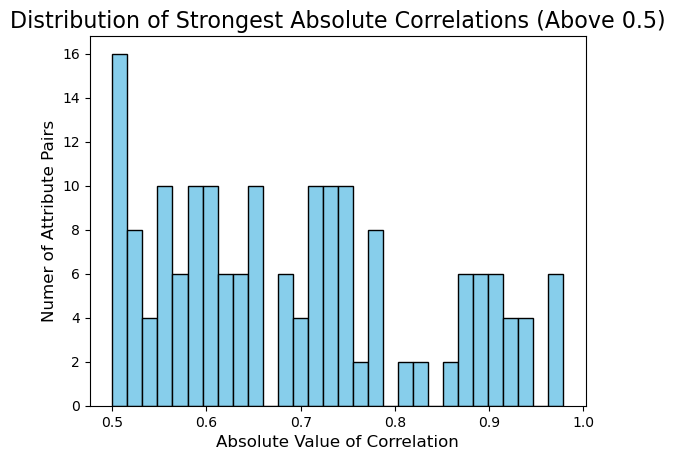

In [355]:
plt.title("Distribution of Strongest Absolute Correlations (Above 0.5)", fontsize=16)
plt.xlabel("Absolute Value of Correlation", fontsize=12)
plt.ylabel("Numer of Attribute Pairs", fontsize=12)
filtered_correlations = correlation_pairs.abs()[correlation_pairs.abs() > 0.5]
plt.hist(filtered_correlations, bins=30, color='skyblue', edgecolor='black')

In [356]:
# How many "strong" correlations (greater than 0.7) are there?
high_correlations = correlation_pairs[correlation_pairs.abs() > 0.7]
high_correlations = high_correlations.sort_values(ascending=False)
print(len(high_correlations))


78


There is multicollinearity in the data, which means we should not assume independence of variables in our models

# Optimal Feature Selection 
## (Note: we have 2 labels: point difference (numeric) and Win (binary))

We have to be careful with years and not use future data to predict past data. We can use "Season" column to generate these training/testing sets but we should not use it or the team IDs as an attribute.

In [357]:
# Example: Use all years before 2020 to train, and 2020-2024 as test
train = tourney_data[tourney_data['Season'] < 2020]
test = tourney_data[tourney_data['Season'] > 2019]

# removing unique columns like ID and year now that we've filtered on year
# also remove PointDiff because is our continuous target we are not using right now
X_train = train.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])  # or whatever your label column is
y_train = train['win']

X_test = test.drop(columns=['PointDiff', 'win', 'Season', 'T1_TeamID', 'T2_TeamID'])
y_test = test['win']

Inspecting missing values (ANOVA doesn't take NA values)

In [358]:
print(len(test))
# Check for missing values in each column
missing_values = test.isnull().sum()

# Filter columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Display the columns with missing values and their counts
print(columns_with_missing)

0
Series([], dtype: int64)


For now, rows with missing values are dropped. We could always use some method of imputing (replacing) these values if we find it affects our performance or think we have a loss of information.

### Selection Using ANOVA (use only binary label)

In [359]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import numpy as np

# Create a SelectKBest object using ANOVA
selector = SelectKBest(f_regression, k=10)  # Select top 2 features

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Get the selected features
selected_features = selector.get_support()
print(f"Selected feature indices: {np.where(selected_features)[0]}")

# Transform the data to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Selection Using LASSO

### Selection Usuing